In [1]:
from modeling.deeplab import *

In [2]:
import argparse
import logging

In [3]:
from PIL import Image

In [4]:
import numpy as np
import matplotlib.pylab as plt

In [5]:
from utils.loss import SegmentationLosses
from torchvision import transforms
from dataloaders import custom_transforms as tr

In [6]:
class get_args():
    
    def __init__(self):
        self.backbone = 'resnet'
        self.dataset = 'tables'
#         self.input = '../TableGenerations/dataset04/train/imgs/test-001.png'
        self.output = './predict/0000.png'
        self.model = './run/tables/deeplab-resnet/experiment_4/checkpoint.pth.tar'
        
        self.out_stride = 16
        self.sync_bn = None
        self.freeze_bn = False
        
        self.batch_size = 1
        self.base_size = 600
        self.crop_size = 600
        
        self.loss_type = "ce"
        self.no_cuda = True
        
        self.cuda = not self.no_cuda and torch.cuda.is_available()
        
        pass

In [7]:
def get_predict_model(args, n_classes):
    net = DeepLab(num_classes=n_classes,
                backbone=args.backbone,
                output_stride=args.out_stride,
                sync_bn=args.sync_bn,
                freeze_bn=args.freeze_bn)

    logging.info("Loading model {}".format(args.model))

    net.to(device=device)
    net.load_state_dict(torch.load(args.model, map_location=device)["state_dict"])
    logging.info("Model loaded !")

    net.eval()
    
    return net

In [8]:
def transform_ts(sample):
    composed_transforms = transforms.Compose([
        tr.FixedResize(size=args.crop_size),
        tr.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        tr.ToTensor()])

    return composed_transforms(sample)

In [30]:
args = get_args()

in_files = "../TableGenerations/paper_data/test04.png" #args.input
out_files = args.output

## number of target classes
n_classes = 3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = get_predict_model(args, n_classes)

In [31]:
img = Image.open(in_files).convert('RGB')

sample = {'image':img, 'label':img}
sample_tr = transform_ts(sample)
with torch.no_grad():
    output = net(sample_tr['image'].unsqueeze(0).cuda())
pred = output.data.cpu()
mask = torch.argmax(output, dim=1).squeeze(0).cpu()
pred_mask = mask.numpy()

In [32]:
class_colors = np.array([[0, 0, 0], #boder line
               [125, 125, 125], # text
               [255, 255, 255]]) # background

In [33]:
r = pred_mask.copy()
g = pred_mask.copy()
b = pred_mask.copy()

In [34]:
for ll in np.arange(0, n_classes):
    r[pred_mask == ll] = class_colors[ll, 0]
    g[pred_mask == ll] = class_colors[ll, 1]
    b[pred_mask == ll] = class_colors[ll, 2]

In [35]:
pred_mask_rgb = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3))
pred_mask_rgb[:, :, 0] = r
pred_mask_rgb[:, :, 1] = g
pred_mask_rgb[:, :, 2] = b
pred_mask_rgb_img = Image.fromarray(pred_mask_rgb.astype(np.uint8))
pred_mask_rgb_img = pred_mask_rgb_img.resize(img.size)
pred_mask_rgb_img.save(in_files + ".test.png")

(1180, 697)

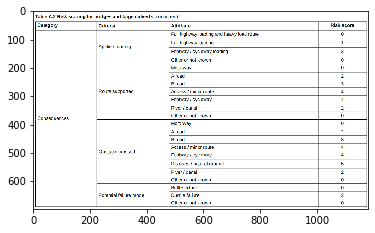

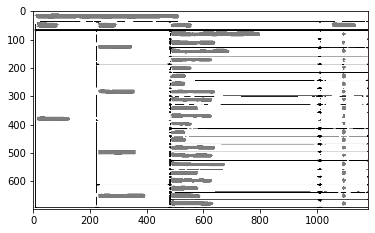

In [36]:
# plt.figure(figsize=(12, 12))
# fig, axis = plt.subplots(1, 2, figsize=(20, 15))
# axis[0].imshow(img)
# axis[1].imshow(pred_mask_rgb_img)
plt.figure()
plt.imshow(img)

plt.figure()
plt.imshow(pred_mask_rgb_img)

pred_mask_rgb_img.size

In [16]:
type(pred_mask_rgb_img)

PIL.Image.Image